In [2]:
from sentinelhub import SHConfig
from dotenv import dotenv_values

# https://shapps.dataspace.copernicus.eu/dashboard/#/account/settings
creds = dotenv_values("../../../.env")  


In [3]:
# https://sentinelhub-py.readthedocs.io/en/latest/configure.html#copernicus-data-space-ecosystem-configuration
config = SHConfig()
config.sh_client_id = creds['client_id']
config.sh_client_secret = creds['client_secret']
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
"""
Utilities used by example notebooks
by https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/utils.py
"""

from __future__ import annotations

from typing import Any

import matplotlib.pyplot as plt
import numpy as np

# 
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# catalog api and process api

In [9]:
from sentinelhub import SentinelHubCatalog
catalog = SentinelHubCatalog(config=config)
catalog.get_info()

{'type': 'Catalog',
 'stac_version': '1.0.0',
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v1.0.0 implementation by Sentinel Hub',
 'conformsTo': ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson',
  'https://api.stacspec.org/v1.0.0/core',
  'https://api.stacspec.org/v1.0.0/collections',
  'https://api.stacspec.org/v1.0.0/ogcapi-features',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#fields',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#context',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#filter',
  'https://api.stacspec.org/v1.0.0/item-search',
  'https://api.stacspec.org/v1.0.0/item-search#fields',
  'https://api.stacspec.org/v1.0.0/item-search#context',
  'https://api.stacspec.org/v1.0.0/item-search#filter',
  'http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter',
  'http

In [77]:
coords_wgs84 = (116.648056,-1.007787,116.751652,-0.940718)
resolution = 60
bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

size = bbox_to_dimensions(bbox, resolution=resolution)
print(f"The image resolution is {resolution} m and the dimensions are {size} pixels")

time_interval = "2022-05-01", "2024-02-24"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=bbox,
    time=time_interval,
    filter="eo:cloud_cover < 0",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

The image resolution is 60 m and the dimensions are (192, 124) pixels
Total number of results: 13


[{'id': 'S2B_MSIL2A_20240221T021729_N0510_R003_T50MMD_20240221T043015.SAFE',
  'properties': {'datetime': '2024-02-21T02:38:14.112Z',
   'eo:cloud_cover': 7.68}},
 {'id': 'S2A_MSIL2A_20240219T022741_N0510_R046_T50MMD_20240219T051150.SAFE',
  'properties': {'datetime': '2024-02-19T02:48:06.539Z',
   'eo:cloud_cover': 8.88}},
 {'id': 'S2A_MSIL2A_20240219T022741_N0510_R046_T50MME_20240219T051150.SAFE',
  'properties': {'datetime': '2024-02-19T02:47:51.777Z',
   'eo:cloud_cover': 13.77}},
 {'id': 'S2A_MSIL2A_20240216T021751_N0510_R003_T50MMD_20240216T050450.SAFE',
  'properties': {'datetime': '2024-02-16T02:38:11.299Z',
   'eo:cloud_cover': 18.74}},
 {'id': 'S2B_MSIL2A_20230927T022539_N0509_R046_T50MME_20230927T054333.SAFE',
  'properties': {'datetime': '2023-09-27T02:47:56.839Z',
   'eo:cloud_cover': 13.33}},
 {'id': 'S2B_MSIL2A_20230904T021539_N0509_R003_T50MMD_20230904T062412.SAFE',
  'properties': {'datetime': '2023-09-04T02:38:18.181Z',
   'eo:cloud_cover': 17.74}},
 {'id': 'S2B_MSIL2

In [92]:
from sentinelhub import filter_times
import datetime as dt

time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

len(unique_acquisitions)

90

In [98]:
process_requests = []


evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""


for timestamp in unique_acquisitions:

    request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url),
            time_interval=(timestamp - time_difference, timestamp + time_difference),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
    )

    process_requests.append(request)

In order to efficiently download data for all requests in parallel, we extract download information and pass it to a download client.



In [106]:

from sentinelhub import SentinelHubDownloadClient

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

(109, 136, 3)

In [86]:
len(data)

12

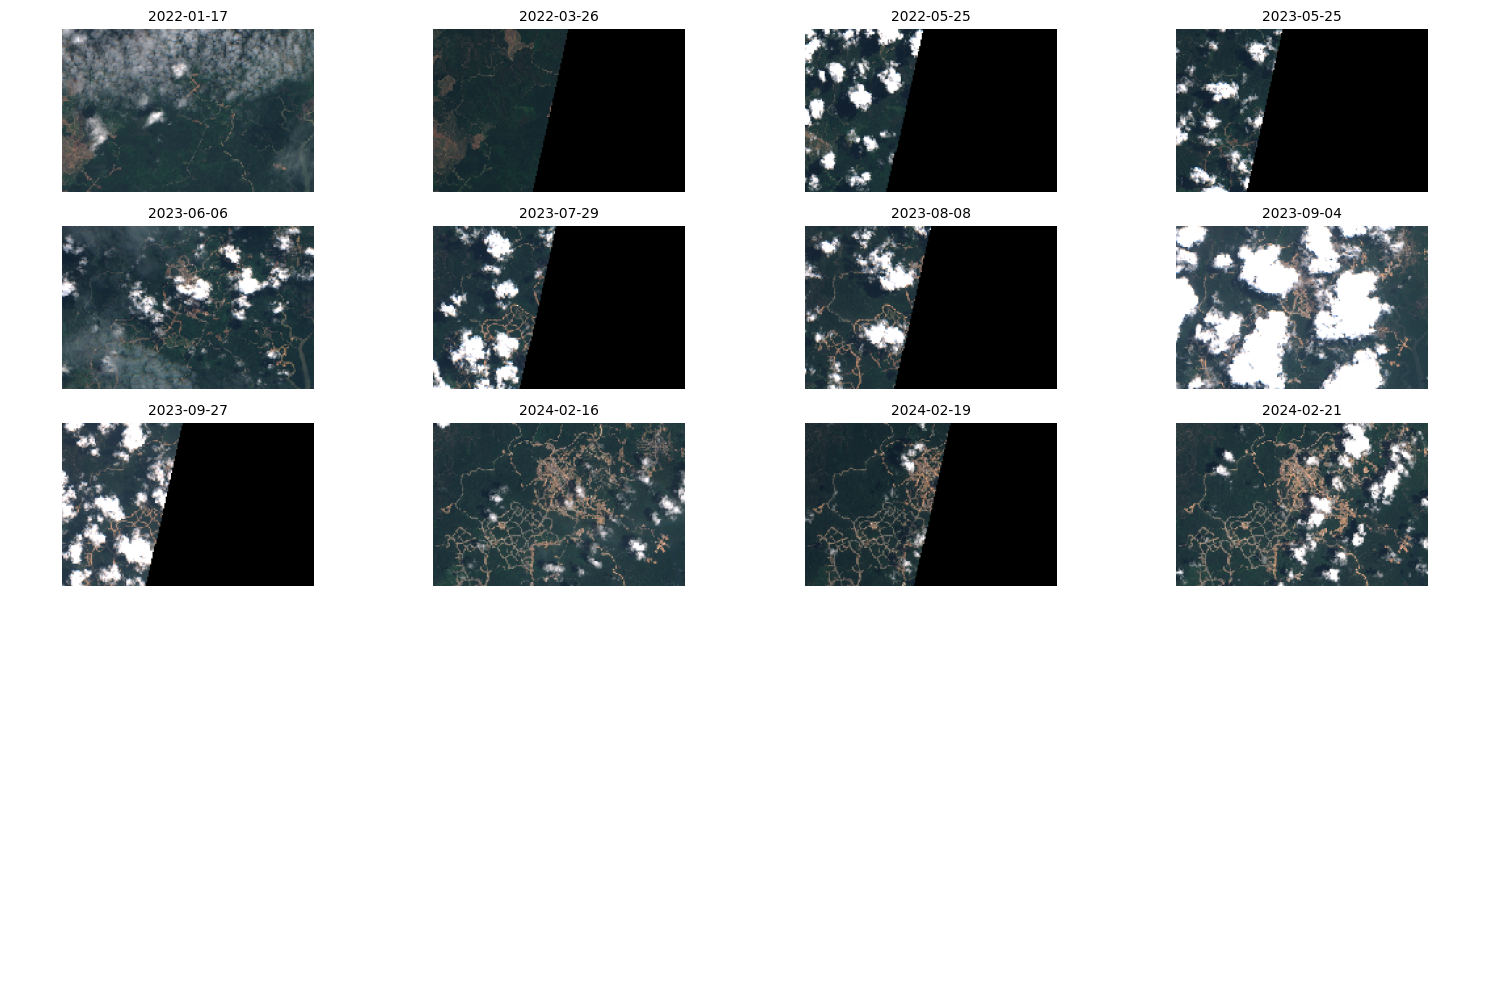

In [83]:
ncols, nrows = 4, 5

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 10), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 1 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()

In [112]:
from PIL import Image

In [121]:

img_collection = [Image.fromarray(img) for img in data]

print(img_collection)
# duration is the number of milliseconds between frames; this is 500 frames per second
img_collection[0].save("timelapse.gif", save_all=True, append_images=img_collection[1:], duration=10, loop=0, optimize=True)

[<PIL.Image.Image image mode=RGB size=1938x431 at 0x122B820D0>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x122CE3A90>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293F250>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293C390>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293E450>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293C310>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293D710>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293FB90>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293C2D0>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x122A7EC50>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293D0D0>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293E090>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293D850>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293D910>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x12293FB10>, <PIL.Image.Image image mode=RGB size=1938x431 at 0x122

# Dam Ukraine


In [52]:
coords_wgs84 = (33.264799,46.742174,33.478205,46.833366)
resolution = 10
bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

size = bbox_to_dimensions(bbox, resolution=resolution)
print(f"The image resolution is {resolution} m and the dimensions are {size} pixels")

time_interval = "2022-02-01", "2024-02-24"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=bbox,
    time=time_interval,
    filter="eo:cloud_cover < 30",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

The image resolution is 10 m and the dimensions are (1624, 1021) pixels
Total number of results: 104


[{'id': 'S2A_MSIL2A_20240104T085351_N0510_R107_T36TWS_20240104T115952.SAFE',
  'properties': {'datetime': '2024-01-04T08:57:13.891Z',
   'eo:cloud_cover': 24.84}},
 {'id': 'S2A_MSIL2A_20240101T084351_N0510_R064_T36TWS_20240101T114651.SAFE',
  'properties': {'datetime': '2024-01-01T08:47:18.071Z',
   'eo:cloud_cover': 6.55}},
 {'id': 'S2B_MSIL2A_20231220T085309_N0510_R107_T36TWS_20231220T103053.SAFE',
  'properties': {'datetime': '2023-12-20T08:57:17.953Z',
   'eo:cloud_cover': 0.86}},
 {'id': 'S2B_MSIL2A_20231130T085229_N0509_R107_T36TWS_20231130T104148.SAFE',
  'properties': {'datetime': '2023-11-30T08:57:14.294Z',
   'eo:cloud_cover': 5.79}},
 {'id': 'S2B_MSIL2A_20231110T085109_N0509_R107_T36TWS_20231110T105045.SAFE',
  'properties': {'datetime': '2023-11-10T08:57:19.083Z',
   'eo:cloud_cover': 0.09}},
 {'id': 'S2B_MSIL2A_20231107T084049_N0509_R064_T36TWS_20231107T102725.SAFE',
  'properties': {'datetime': '2023-11-07T08:47:23.663Z',
   'eo:cloud_cover': 0.13}},
 {'id': 'S2A_MSIL2A_2

In [53]:
from sentinelhub import filter_times
import datetime as dt

time_difference = dt.timedelta(days=4)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

len(unique_acquisitions)

68

In [55]:
process_requests = []


evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [3 * sample.B04, 3 * sample.B03, 3 * sample.B02];
    }
"""


for timestamp in unique_acquisitions:

    request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            DataCollection.SENTINEL2_L1C.define_from("s2l1c", service_url=config.sh_base_url),
            time_interval=(timestamp - time_difference, timestamp + time_difference),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    size=size,
    config=config,
    )

    process_requests.append(request)

In [56]:

from sentinelhub import SentinelHubDownloadClient

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data

/Users/martinsiklar/Code/eoai-playground/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:91: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/martinsiklar/Code/eoai-playground/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:91: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/martinsiklar/Code/eoai-playground/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:91: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/martinsiklar/Code/eoai-playground/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:91: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/Users/martinsiklar/Code/eoai-playground/.ve

[array([[[ 68,  70,  92],
         [ 68,  69,  92],
         [ 69,  70,  92],
         ...,
         [ 29,  48,  77],
         [ 29,  49,  76],
         [ 29,  47,  77]],
 
        [[ 67,  69,  92],
         [ 68,  70,  93],
         [ 68,  70,  91],
         ...,
         [ 28,  49,  76],
         [ 31,  50,  77],
         [ 31,  50,  77]],
 
        [[ 69,  69,  90],
         [ 68,  69,  92],
         [ 66,  70,  90],
         ...,
         [ 29,  50,  77],
         [ 30,  49,  77],
         [ 29,  49,  78]],
 
        ...,
 
        [[106,  95, 116],
         [ 78,  76,  97],
         [ 57,  64,  89],
         ...,
         [ 65,  76,  93],
         [ 65,  71,  92],
         [ 63,  70,  90]],
 
        [[ 99,  87, 110],
         [ 64,  70,  89],
         [ 53,  61,  87],
         ...,
         [ 67,  75,  94],
         [ 65,  71,  93],
         [ 63,  70,  90]],
 
        [[ 87,  79, 102],
         [ 61,  68,  89],
         [ 56,  64,  88],
         ...,
         [ 68,  76,  93],
  

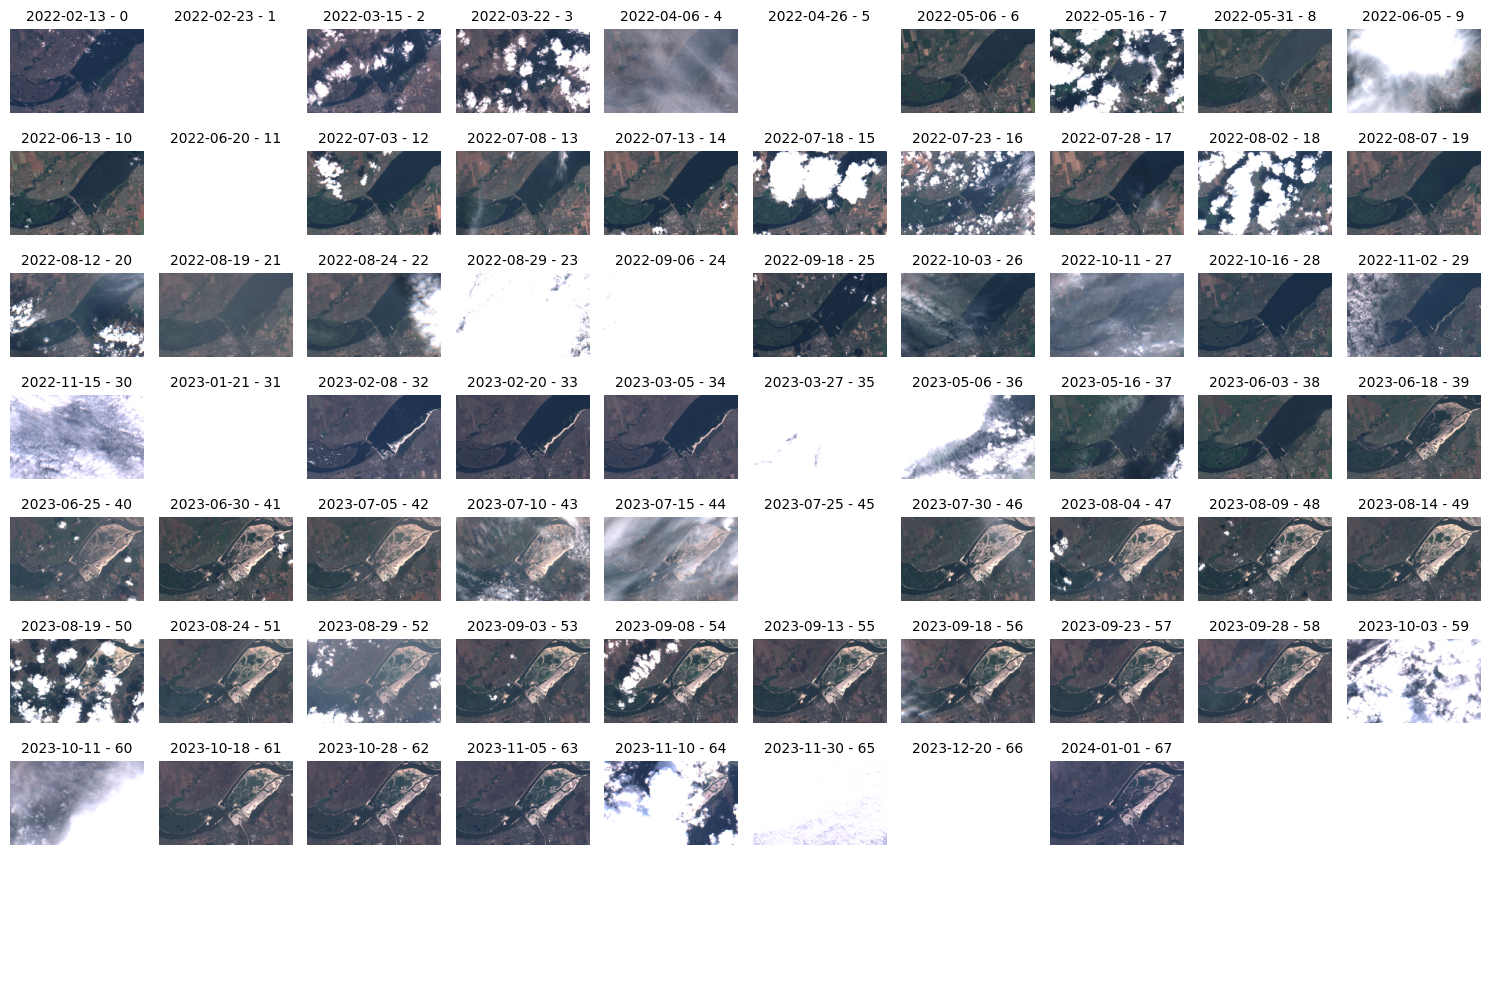

In [57]:
ncols, nrows = 10, 8

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 10), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 1 / 255, 0, 1))
    ax.set_title(f"{timestamp.date().isoformat()} - {idx}", fontsize=10)

plt.tight_layout()

qi = [0,6,8,10,14,17,19,25,28,32,34,38,39,40,41,42,47,49,51,53,55,57,58,62,67]

In [89]:
sub_data = []
time = []
for idx,img in enumerate(data):
    if idx in qi:
        sub_data.append(img)
        time.append(unique_acquisitions[idx].date().isoformat())


len(sub_data)
len(time)

25

In [99]:
from PIL import Image, ImageDraw, ImageFont


font = ImageFont.truetype("/Users/martinsiklar/Library/Fonts/MesloLGS NF Regular.ttf", size=25)

In [100]:

img_collection = []

for idx, img in enumerate(sub_data):
    pil_img = Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)
    draw.text((20,20), time[idx], (255,255,255), font=font)

    img_collection.append(pil_img)

In [103]:


# duration is the number of milliseconds between frames; this is 500 frames per second
img_collection[0].save("timelapse.gif", save_all=True, append_images=img_collection[1:], duration=150, loop=0, optimize=True)